<a href="https://colab.research.google.com/github/Manwa94/Bert_MULTI_LABEL_TEXT_CLASSIFICATION/blob/main/MULTI_LABEL_TEXT_CLASSIFICATION_USING__BERT_AND_PYTORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Apr 23 10:12:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional.classification import auroc

from sklearn.model_selection import train_test_split

In [ ]:
!pip install git+https://github.com/PytorchLightning/pytorch-lightning
import pytorch_lightning as pl
print(pl.__version__)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PytorchLightning/pytorch-lightning to /tmp/pip-req-build-pb7m7jq1
  Running command git clone --filter=blob:none --quiet https://github.com/PytorchLightning/pytorch-lightning /tmp/pip-req-build-pb7m7jq1
  Resolved https://github.com/PytorchLightning/pytorch-lightning to commit 92b379e90a8592e4f02beaa28b913fa825a96eb2
  Running command git submodule update --init --recursive -q
  Encountered 31 file(s) that should have been pointers, but weren't:
        .notebooks/course_UvA-DL/01-introduction-to-pytorch.ipynb
        .notebooks/course_UvA-DL/02-activation-functions.ipynb
        .notebooks/course_UvA-DL/03-initialization-and-optimization.ipynb
        .notebooks/course_UvA-DL/04-inception-resnet-densenet.ipynb
        .notebooks/course_UvA-DL/05-transformers-and-MH-attention.ipynb
        .notebooks/course_UvA-DL/06-graph-neural-networks.ipynb
        .notebo

In [ ]:
pip install -q test_tube transformers pytorch-nlp pytorch-lightning==0.9.0

In [72]:
df = pd.read_csv('/train.csv')

In [73]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [74]:
df.shape

(159571, 8)

In [75]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [76]:
train_df,test_df=train_test_split(df,test_size=0.1)
train_df.shape,test_df.shape

((143613, 8), (15958, 8))

In [77]:
CLASSES=df.columns.to_list()[2:]
CLASSES

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

<Axes: >

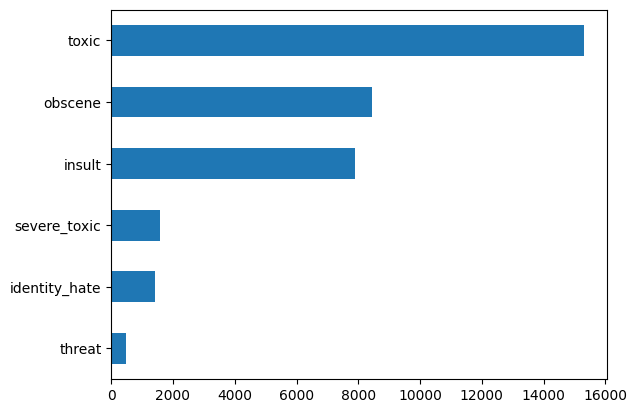

In [78]:
df[CLASSES].sum().sort_values().plot(kind="barh")

In [81]:
#check how many have labels
toxic_df=df[df[CLASSES].sum(axis=1)>0]
toxic_df.shape

(16225, 8)

In [82]:
clean_df=df[df[CLASSES].sum(axis=1)==0]
clean_df.shape

(143346, 8)

In [84]:
#There are around 14 lakhs with no labels
clean_df=clean_df.sample(16_000)
clean_df.shape

(16000, 8)

In [85]:
train_df=pd.concat([toxic_df,clean_df])
train_df.shape

(32225, 8)

In [87]:
train_df=train_df[:2000]

In [88]:
BERT_MODEL_NAME='bert-base-cased'
tokenizer=BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
#DATA PREPROCESSING

In [89]:
class ToxicCommentsDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_len: int = 128
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        single_row = self.data.iloc[index]
        
        comment = single_row.comment_text
        labels = single_row[CLASSES]

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "comment_text": comment,
            "input_ids": encoding["input_ids"].flatten(), # [1,512] => [512]
            "attention_mask": encoding["attention_mask"].flatten(), # [1,512] => [512]
            "labels": torch.FloatTensor(labels)
        }
     

train_dataset = ToxicCommentsDataset(train_df, tokenizer)
     

sample_data = train_dataset[0]
     

print(sample_data["comment_text"])
print()
print(sample_data["input_ids"])
print()
print(sample_data["attention_mask"])
print()
print(sample_data["labels"])


COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

tensor([  101, 18732,  1658, 25370, 21986, 22441,  2069,   139, 14663,  9565,
         2036, 19141,   153,  6258,  1708, 22133,  2346, 27370,  2137, 21748,
          150,  3663,   160,  9565,  2428,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    

In [90]:
class ToxicCommentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_len=128):
        super().__init__()
        
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_len = max_len
    
    def setup(self, stage=None):
        self.train_dataset = ToxicCommentsDataset(self.train_df, self.tokenizer, self.max_len)
        self.test_dataset = ToxicCommentsDataset(self.test_df, self.tokenizer, self.max_len)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            num_workers=4
        )    
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            num_workers=4
        )
     

EPOCHS = 10
BATCH_SIZE = 4
     

data_module = ToxicCommentDataModule(
    train_df, 
    test_df, 
    tokenizer, 
    batch_size=BATCH_SIZE
)
data_module.setup()

In [91]:
#Model building


class ToxicCommentClassifier(pl.LightningModule):
    def __init__(self, n_classes: int, steps_per_epoch=None, n_epochs=None):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {
            "loss": loss,
            "predictions": outputs,
            "labels": labels
        }

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def on_train_epoch_end(self):
        labels = []
        predictions = []
        
        # for output in outputs:
        #     for out_labels in output["labels"].detach().cpu():
        #         labels.append(out_labels)

        #     for out_predictions in output["predictions"].detach().cpu():
        #         predictions.append(out_predictions)

        # labels = torch.stack(labels).int()
        # predictions = torch.stack(predictions)

        # for i, name in enumerate(CLASSES):
        #     roc_score = auroc(predictions[:, i], labels[:, i])
        #     self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", roc_score, self.current_epoch)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        warmup_steps = self.steps_per_epoch // 3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
        scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer], [scheduler]
     

model = ToxicCommentClassifier(
    n_classes=len(CLASSES), 
    steps_per_epoch=len(train_df)//BATCH_SIZE, 
    n_epochs=EPOCHS
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [92]:

trainer = pl.Trainer(max_epochs=EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [93]:
trainer.fit(model, data_module)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 4.6 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.260   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [94]:
trainer.save_checkpoint("last-checkpoint.ckpt")

In [95]:
trained_model = ToxicCommentClassifier.load_from_checkpoint("last-checkpoint.ckpt", n_classes=len(CLASSES))
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [96]:
test_example = "i love you"

In [97]:
encoding = tokenizer.encode_plus(
    test_example,
    add_special_tokens=True,
    max_length=128,
    return_token_type_ids=False,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors="pt"
)

In [98]:

model.eval()
_, preds = model(encoding["input_ids"], encoding["attention_mask"])
preds = preds.flatten().detach().numpy()

In [99]:
predictions = []
for idx, label in enumerate(CLASSES):
    if preds[idx] > 0.5:
        predictions.append((label, round(preds[idx]*100, 2)))

predictions
     

[('toxic', 90.2)]